<a href="https://colab.research.google.com/github/dylan33smith/LunarLandingRL/blob/main/AIproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparing RL Algorithms using OpenAI's Gym Lunar Landing Environment**

Dylan Smith <br>
CSPB 3202: Fall 2023<br>
Final Project<br>
Github URL: https://github.com/dylan33smith/LunarLandingRL<br>

<br>

**Project Statement**<br>
For this project, I am comparing 3 different RL Algorithms by training each model on the same environment over the same amount of time steps. The environment is obtained utilizing OpenAI's Gymnasium library and the models will be implemented using the Stable Baseline3 library. Visuals will be obtained and displayed using IPython display and imageio.

**Models**<br>
The three models are for comparison are defined below.
- DQN (Deep Q-Network)
  - DQN functions by extending the Q-learning algorithm by using a deep neural network to approximate the Q-value function (which estimates the "quality" of taking an action in a given state). DQN uses value based methods in which the focus is to learn the value function and then derive the policy from that result.
- PPO (Proximal Policy Optimization)
  - PPO is a method based on policy gradients with the addition of a limited update which helps to prevent substantial policy changes resulting in smoother learning. PPO is a policy based method in that it tires to directly learn the policy by representing it as a probability distribution over actions and then adjusting that distribution to maximize rewards. This aspect of being policy based makes PPO fairly versatile and as such it can be used in discrete or continuous environments.
- A2C (Advantage Actor-Critic)
  - A2C is an approach that is somewhat between the other two. It uses two networks, an actor and a critic, which provides a balance between policy and value baesd approaches. The actor outputs the best (predicted) action, and the critic evaluates the action by estimating the value function.


**Environment**<br>
The above models were trained in the OpenAI Gymnasiums LunarLander-v2 environment. This is a rocket trajectory optimization problem with an action space containing 4 discrete actions: do nothing, fire left engine, fire main engine, or fire right engine. The goal of the lander is to land in a landing pad with each leg in contact with the ground. For each step, the reward:
- is increased/decreased the closer/further the lander is to the pad
- is increased/decreased the slower/faster the lander is moving
- is decreased the more the lander is tilted
- is increased by 10 for each leg in contact with the ground
- is decreased by .03 each frame a side engine is firing
- is decreased by .3 each frame the main engine is firing

The episode recieves an additional reward of +/- 100 for landing safely or crashing respectively.

The model is considered solved when it obtains a score of 200.

This environment can be defined discretely or continuously, but for this project was defined discretely in order to be able to use the DQN model (only works in discrete).

**Approach**<br>
In order to compare these algorithms, models will be built for each and trained towards the same purpose of maximizing the reward in the Lunar Lander model. A good reward score corresponds to the lander landing on its legs on the landing platform. Comparing these algorithms entails measuring how well they learn. The main metric for this will be the measure of how they learn when fully trained, but measuring their rate of improvement throughout training can also indicate suitability for this specific environment. <br>

Each model will be measured at 3 different levels of training. Initial (0 time steps) to get a sense of the random behaviour. 10000 time steps to get a sense of the effects of a small amount of training. And then 100000 time steps to get a sense of the behaviour of the model once training has had more time to develop the model. An episode of each level will be shown to visually assess the effects of each level of training. During the 100000 time step training section, the model will be evaluated at each 10000 time step interval to assess and compare each models rate of learning. <br>

The metric to assess and compare the different models will be the mean_reward and stdev_reward of the model over 30 episodes using Stable Baselines evaluate_policy function. This will give us a measure of how well each model performs as well as how consistently it performs.






### **Preparing Environment**

In [ ]:
# install box2d for gymnasium environments and stable_baselines3 for models
!apt-get update && apt-get install swig cmake
!pip install box2d-py
!pip install "stable-baselines3[extra]>=2.0.0a4"

In [146]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from IPython.display import Image, display
import imageio

## **Models**

### **Custom Functions and Classes**

In [182]:
def evaluate_policy_and_create_video(model, gif_name, suppress=False):
    '''
    This function takes a model and a file name for a gif image as input. It then evaluates the model,
    displays and returns the results.
    A seperate episode is run in order to create and save a gif and then print it inline in the notebook.
    30 episodes were run to minimize std dev.

    Parameters:
    model: a model specific to the LunarLander-v2 environment.
    gif_name: file of gif created from running an episode. Saved to current folder.

    Returns:
    mean_reward: the mean reward from all episodes in the policy evaluation
    std_reward: the standard deviation of the rewards
    '''


    if not gif_name.endswith(".gif"):
      gif_name = gif_name + ".gif"

    # run evaluate policy to evaluate the model
    env = gym.make("LunarLander-v2")
    mean_reward, std_reward = evaluate_policy(
                                model,
                                env,
                                n_eval_episodes=30,
                                deterministic=True,
                                )

    # print(f"mean_reward: {mean_reward:9.2f} +/- {std_reward:9.2f}");

    # episodes to build gif
    if not suppress:
      images = []
      obs = model.env.reset()
      img = model.env.render(mode="rgb_array")
      done = False
      while not done:
          images.append(img)
          action, _ = model.predict(obs)
          obs, _, done, _ = model.env.step(action)
          img = model.env.render(mode="rgb_array")

      # Save the images as a GIF
      imageio.mimsave(gif_name, [np.array(img) for i, img in enumerate(images) if i % 2 == 0], fps=29)

      # Display the GIF in the notebook
      display(Image(open(gif_name, 'rb').read(), format='png'))

    return mean_reward, std_reward


In [257]:
class CustomCallback(BaseCallback):
    '''
    This custom class evaluates the model during learning every 10000 steps
    This allows us to evaluate how the model is performing (by mean and stddev reward at each stop) throughout training
    Once learning has been complete, the change in mean reward and stdev reward is plotted to show progress
    '''

    def __init__(self, env, eval_freq = 10000, verbose = 1):
        super().__init__(verbose)
        self.env = env
        self.eval_freq = eval_freq
        self.mean_rewards = []
        self.std_rewards = []
        self.time_steps = []

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            # print("on step called")
            mean, std = evaluate_policy(self.model, self.env, n_eval_episodes=10)
            self.mean_rewards.append(mean)
            self.std_rewards.append(std)
            self.time_steps.append(self.n_calls)
            if self.verbose > 0:
                print(f"Step {self.n_calls}: Mean reward: {mean:9.2f}, Std reward: {std:9.2f}")
        return True

    def _on_training_end(self) -> None:
        # print("on training end called")
        plot_mean_stddev(self.mean_rewards, self.std_rewards, self.time_steps)

In [224]:

def plot_mean_stddev(means, stdevs, timesteps):
    '''
    Plot the change in mean reward and stdev reward over timesteps

    Parameters:
    means: list of mean rewards over 10 episodes
    stdevs: list of stdevs over 10 episodes
    timesteps: list of timesteps (during model training) at which the model was evaluated
    '''

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plotting the means
    axs[0].plot(timesteps, means, label='Mean')
    axs[0].set_title('Change in Mean Over Time')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Mean')

    # Plotting the standard deviations
    axs[1].plot(timesteps, stdevs, label='Standard Deviation', color='orange')
    axs[1].set_title('Change in Standard Deviation Over Time')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Standard Deviation')

    # Display the plot
    plt.show()




In [78]:
# silence deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [277]:
# set Lunar Lander environment for notebook
env = gym.make("LunarLander-v2")

## **DQN model**


In [243]:
# set custom callback
callback = CustomCallback(env, eval_freq=10000, verbose=1)

In [305]:
# Parameters
  # MlpPolicy: multi-layer perceptron (feedforward neural net)
  # LunarLander-v2: environment on which the model will be trained
    # goal is to land the lander between two flags
  # verbose: controls how much information the model will output during training
  # exploration_final_eps: controls the epsiolon value in the epsilon greedy strategy
    # balances exploration and exploitation
    # specific to DQN
  # target_update_interval: specifies how often the target network is updated
    # every interval, the target weights are updated to match those of the main network

dqn_model = DQN(
    "MlpPolicy",
    "LunarLander-v2",
    verbose=0,
    )


**Baseline initial DQN model with random weights**

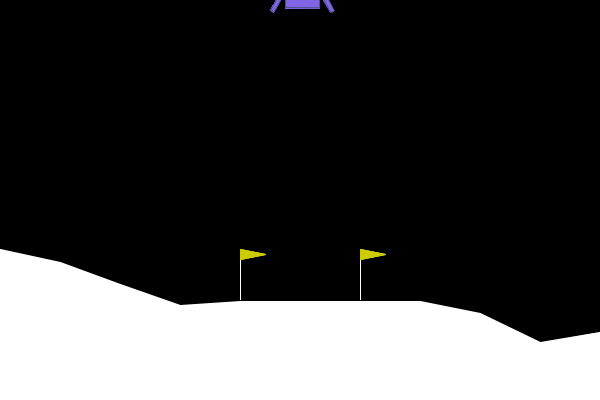

mean_reward:   -565.29   +/-    138.67


In [306]:
gif_name = "random_dqn.gif"
mean_random_dqn, std_random_dqn = evaluate_policy_and_create_video(dqn_model, gif_name);
print(f"mean_reward: {mean_random_dqn:9.2f}   +/- {std_random_dqn:9.2f}")

**Light 10000 time step training DQN model**

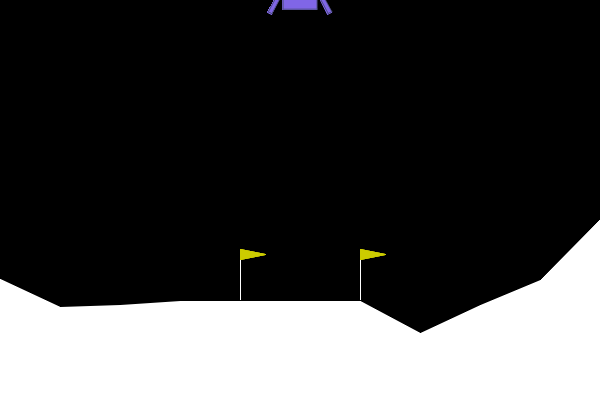

mean_reward:   -605.96   +/-    152.81


In [307]:
# light 10000 time step training of the DQN agent
dqn_model.learn(total_timesteps=10000)
dqn_model.save('light_dqn_ll')

# Measure and visualize light training model
gif_name = "light_dqn.gif"
mean_light_dqn, std_light_dqn = evaluate_policy_and_create_video(dqn_model, gif_name);
print(f"mean_reward: {mean_light_dqn:9.2f}   +/- {std_light_dqn:9.2f}")

**Fully trained 100000 time step DQN model**

In [308]:
# Reset the model so light training doesn't influence the longer training
dqn_model = DQN(
    "MlpPolicy",
    "LunarLander-v2",
    verbose=0,
    exploration_final_eps=0.1, # model will choose a random action with a 10% probability
    target_update_interval=250, # change this to compare learning
    )

# reset custom callback
callback = CustomCallback(env, eval_freq=10000, verbose=1)

Step 10000: Mean reward:   -611.89, Std reward:    186.77
Step 20000: Mean reward:   -660.03, Std reward:    117.87
Step 30000: Mean reward:   -580.09, Std reward:     96.95
Step 40000: Mean reward:   -633.46, Std reward:    114.45
Step 50000: Mean reward:   -546.83, Std reward:    215.52
Step 60000: Mean reward:   -198.13, Std reward:    105.79
Step 70000: Mean reward:    -54.65, Std reward:     27.83
Step 80000: Mean reward:    111.13, Std reward:     78.36
Step 90000: Mean reward:    233.29, Std reward:     20.92
Step 100000: Mean reward:    224.88, Std reward:     36.94


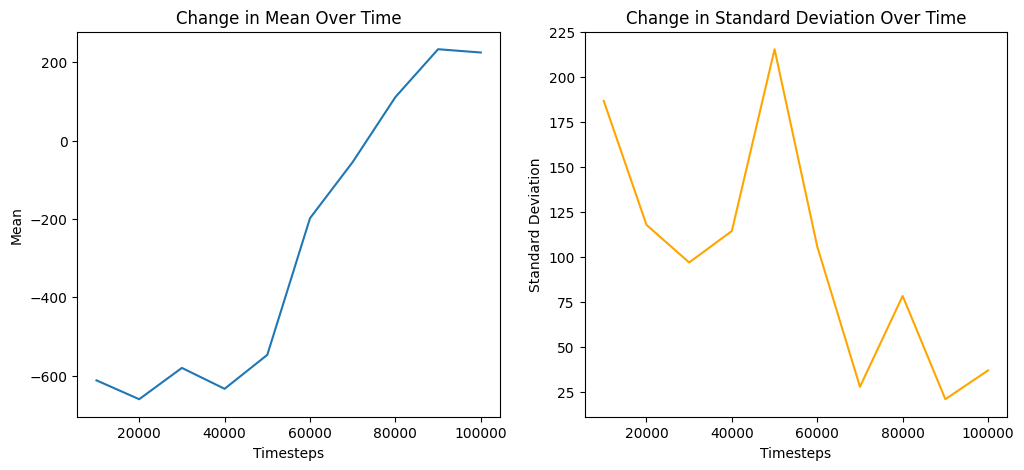

In [309]:
# 100000 training of the DQN agent
dqn_model.learn(total_timesteps=100000, callback = callback)
dqn_model.save('light_dqn_ll')

# (11s)

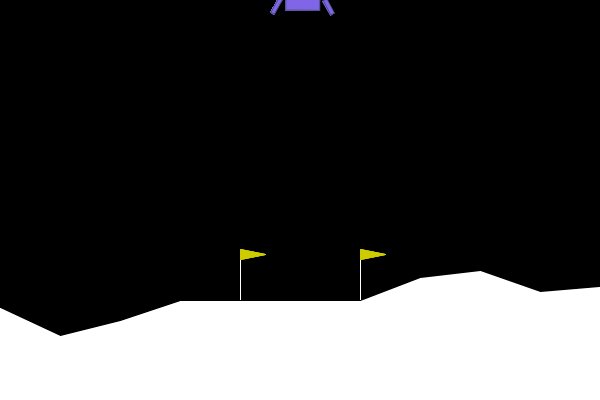

mean_reward:    192.81   +/-     79.21


In [310]:
gif_name = "trained_dqn.gif"
mean_train_dqn, std_train_dqn = evaluate_policy_and_create_video(dqn_model, gif_name);
print(f"mean_reward: {mean_train_dqn:9.2f}   +/- {std_train_dqn:9.2f}")

In [336]:
# code to measure trained a2c success rate
model = DQN.load('dqn_ll.zip', env=env)

# have to use vec_env in stable_baseline
vec_env = model.get_env()
num_successes = 0
obs = vec_env.reset()

for i in range(100):

    done = False
    while not done:
        action, states = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        if done and reward >= 200:
          num_successes += 1

dqn_success_rate = num_successes
print(f"Success rate: {dqn_success_rate}%")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Success rate: 0%


**DQN summary:**<br>
 <br>

From the graphs above showing the improvement throughout training, we can see that the model does indeed improve as it trains. Initially, improvement in the efficacy of the training is sporadic (mean graph), but at 50000 time steps, there is a substantial jump in improvement. At this point, each subsequent block of 10000 timesteps required substantially longer than the first 5 blocks. We also see a steep decline in the stdev reward of the model at this point. All of this indicates that something significant happens in the training at about 50000 time steps that siginificantly alters the functioning of the model. This could be due to the model decreasing its exploration as training progress. The earlier stages could have been the model exploring the space, and the jump could be when the space was fully (or mostly) explored. The substantial decrease in deviation at this moment backs up this theory. The model still improves after this 50000 time step jump though which indicates that the behaviour isn't due to network convergence.<br>

In comparing the performance of the model at the three stages of learning, we can see that the model improves significantly as it learns. The model only consistently obtains a positive reward at around 80000 time steps, and never consistently reaches the complete solution (defined as 200 points). Visually, the longer trained model can be seen to have learned to stabalize itself as well as to control its speed which is in contrast to the visualization of the random or lightly trained model.

# **PPO Model**



In [250]:
# set custom callback
callback = CustomCallback(env, eval_freq=10000, verbose=1)

In [282]:
# Parameters
ppo_model = PPO(
    "MlpPolicy",
    "LunarLander-v2",
    verbose=0,
    )

**Baseline initial PPO model with random weights**

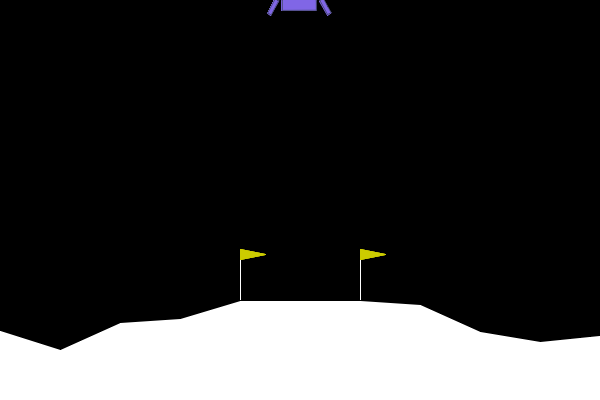

mean_reward:   -476.29   +/-    403.03


In [241]:
gif_name = "random_ppo.gif"
mean_random_ppo, std_random_ppo = evaluate_policy_and_create_video(ppo_model, gif_name);
print(f"mean_reward: {mean_random_ppo:9.2f}   +/- {std_random_ppo:9.2f}")

**Light 10000 time step training PPO model**

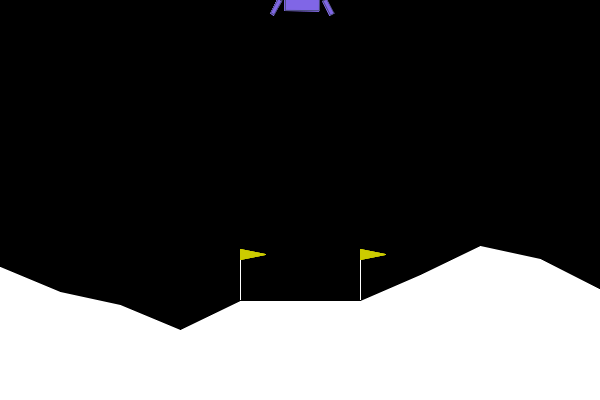

mean_reward:   -859.58   +/-    354.87


In [283]:
# light 10000 time step training of the PPO agent
ppo_model.learn(total_timesteps=10000)
ppo_model.save('light_ppo_ll')

# Measure and visualize light training model
gif_name = "light_ppo.gif"
mean_light_ppo, std_light_ppo = evaluate_policy_and_create_video(ppo_model, gif_name);
print(f"mean_reward: {mean_light_ppo:9.2f}   +/- {std_light_ppo:9.2f}")

**Fully trained 100000 time step PPO model**

In [284]:
# Reset the model so light training doesn't influence the longer training
ppo_model = PPO(
    "MlpPolicy",
    "LunarLander-v2",
    verbose=0,
    )

# reset custom callback
callback = CustomCallback(env, eval_freq=10000, verbose=1)

Step 10000: Mean reward:   -232.59, Std reward:    103.35
Step 20000: Mean reward:  -2479.58, Std reward:    849.73
Step 30000: Mean reward:  -2399.57, Std reward:    903.47
Step 40000: Mean reward:  -1208.18, Std reward:    554.55
Step 50000: Mean reward:   -562.30, Std reward:    153.18
Step 60000: Mean reward:   -974.72, Std reward:    176.59
Step 70000: Mean reward:   -330.82, Std reward:     20.02
Step 80000: Mean reward:    -89.61, Std reward:     25.39
Step 90000: Mean reward:   -171.49, Std reward:     59.65
Step 100000: Mean reward:    -80.04, Std reward:     27.76


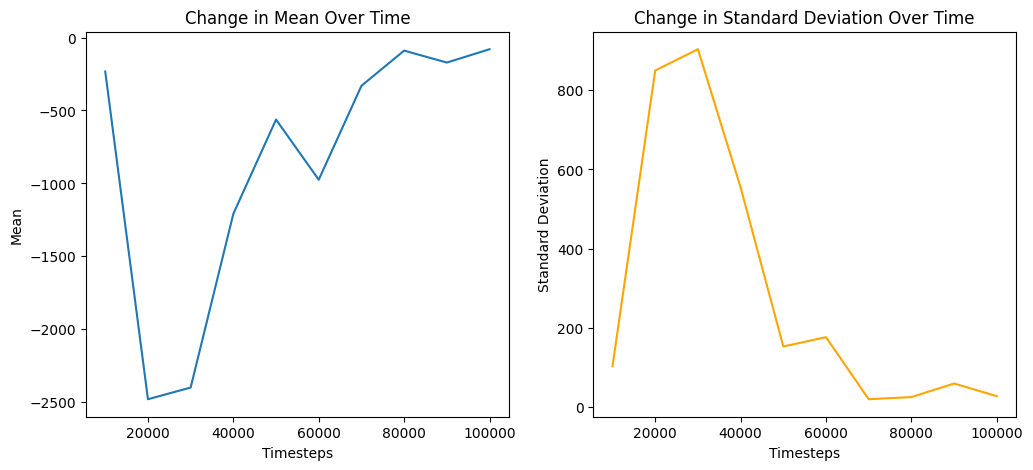

In [285]:
# training the PPO agent
# have to reset the call back if training happens twice or else
ppo_model.learn(total_timesteps=100000, callback=callback)
ppo_model.save('ppo_ll')

# (5m 51s for 1e5 timesteps)

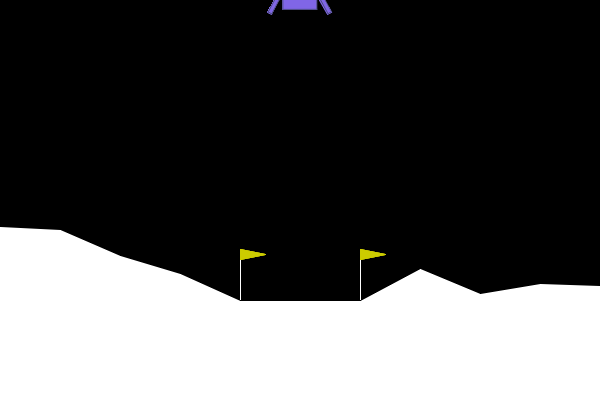

mean_reward:    -86.44   +/-     31.28


In [286]:
# Trained PPO model
gif_name = "trained_ppo.gif"
mean_trained_ppo, std_trained_ppo = evaluate_policy_and_create_video(ppo_model, gif_name);
print(f"mean_reward: {mean_trained_ppo:9.2f}   +/- {std_trained_ppo:9.2f}")
# 38s

In [335]:
# code to measure trained a2c success rate
model = PPO.load('ppo_ll.zip', env=env)

# have to use vec_env in stable_baseline
vec_env = model.get_env()
num_successes = 0
obs = vec_env.reset()

for i in range(100):

    done = False
    while not done:
        action, states = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        if done and reward >= 200:
          num_successes += 1

ppo_success_rate = num_successes
print(f"Success rate: {ppo_success_rate}%")

Success rate: 0%


**PPO Summary:**<br>
In comparing the initial random-weight model to the lightly trained model, we can see that this limited amount of training has a negative affect on performance. Despite that, when comparing the gifs of the random and lightly trained models, we can see an interesting thing in that it has already learned to land on it's legs. The speed at which this is learned is likely due to the size of the reward for this behaviour. Crashing gives a reward of -100 whereas coming to rest recieves a reward of +100. Further, each leg with ground contact recieves +10 reward. These termination state rewards are significantly larger than the time step rewards, so it is perhaps unsurprising that the model learns this behavious so quickly.

From the graphs above, we can see that this model has a substantial initial decrease in performance and consistency, and only begins to consistently improve performance and consistency after around 30000 time steps. These initial stages where performance decreases can likely be attributed to the model being in the exploration phase. During this phase, the agent makes more suboptimal choices that lead to lower rewards and higher variability in performance. It is hard to say for sure, but the performance of the model seems to be leveling out in the further stages of training indicating it could be converging. If that is the case, then it is likely due to the simplicity of the model and could be improved by adjusting the models parameters. <br>

In comparing the performance of the model at the three stages of learning, we can see that the models performance initially decreases but ends up improving after a few inital stages. In the visualization of the final trained model, we can see that it has learned to stabalize itself and to control its speed in addition to landing on its legs without crashing that it learned by the lightly trained stage.

# **A2C Model**

In [299]:
# set custom callback
callback = CustomCallback(env, eval_freq=10000, verbose=1)

In [301]:
# Parameters

a2c_model = A2C(
    "MlpPolicy",
    "LunarLander-v2",
    verbose=0,
    )

**Baseline initial A2C model with random weights**

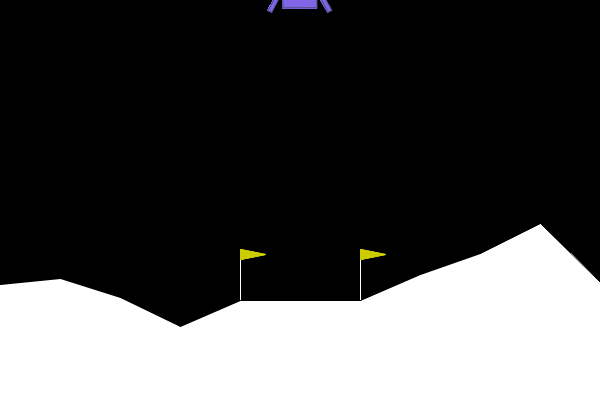

mean_reward:  -1022.10   +/-    566.73


In [303]:
gif_name = "random_a2c.gif"
mean_random_a2c, std_random_a2c = evaluate_policy_and_create_video(a2c_model, gif_name);
print(f"mean_reward: {mean_random_a2c:9.2f}   +/- {std_random_a2c:9.2f}")

**Light 10000 time step training A2C model**

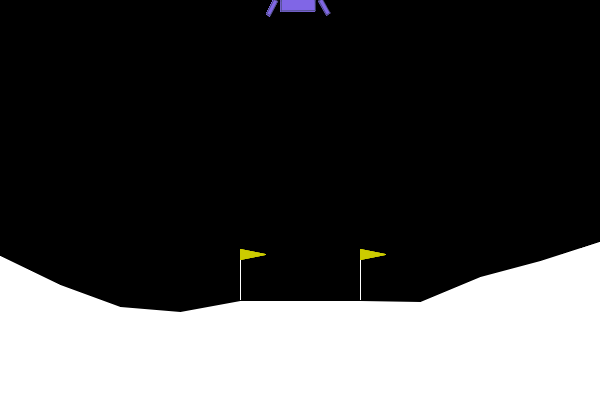

mean_reward:   -304.54   +/-    458.03


In [300]:
# light 10000 time step training of the A2C agent
a2c_model.learn(total_timesteps=10000)
a2c_model.save('light_a2c_ll')

# Measure and visualize light training model
gif_name = "light_a2c.gif"
mean_light_a2c, std_light_a2c = evaluate_policy_and_create_video(a2c_model, gif_name);
print(f"mean_reward: {mean_light_a2c:9.2f}   +/- {std_light_a2c:9.2f}")

**Fully trained 100000 time step PPO model**

In [291]:
# Reset the model so light training doesn't influence the longer training
a2c_model = A2C(
    "MlpPolicy",
    "LunarLander-v2",
    verbose=0,
    )

# reset custom callback
callback = CustomCallback(env, eval_freq=10000, verbose=1)

Step 10000: Mean reward:   -311.50, Std reward:    302.70
Step 20000: Mean reward:    -68.92, Std reward:    177.61
Step 30000: Mean reward:   -128.11, Std reward:     70.19
Step 40000: Mean reward:     43.48, Std reward:    144.12
Step 50000: Mean reward:    -20.97, Std reward:    156.15
Step 60000: Mean reward:    169.48, Std reward:    106.75
Step 70000: Mean reward:     98.57, Std reward:    125.11
Step 80000: Mean reward:    -46.33, Std reward:     55.06
Step 90000: Mean reward:   -121.95, Std reward:     25.93
Step 100000: Mean reward:   -144.13, Std reward:     38.55


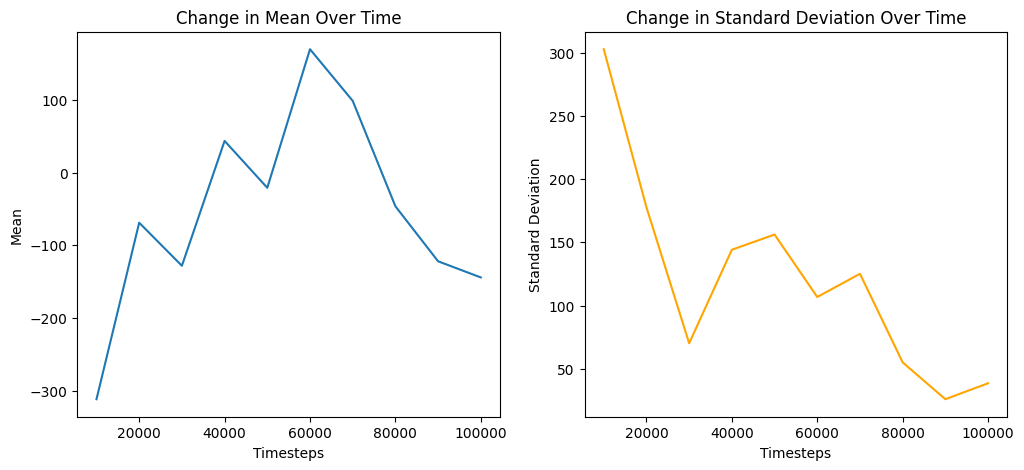

In [292]:
# training the A2C agent
a2c_model.learn(total_timesteps=100000, callback=callback)
a2c_model.save('a2c_ll')

# (5m 51s for 1e5 timesteps)

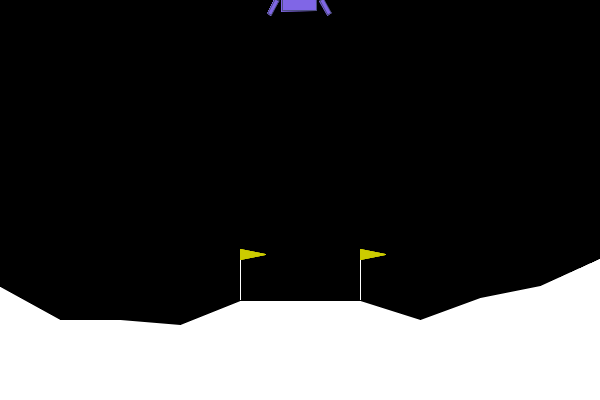

mean_reward:  -1099.27   +/-    742.32


In [314]:
# Trained A2C model
gif_name = "trained_a2c.gif"
mean_trained_a2c, std_trained_a2c = evaluate_policy_and_create_video(a2c_model, gif_name);
print(f"mean_reward: {mean_trained_a2c:9.2f}   +/- {std_trained_a2c:9.2f}")

In [333]:
# code to measure trained a2c success rate
model = A2C.load('a2c_ll.zip', env=env)

# have to use vec_env in stable_baseline
vec_env = model.get_env()
num_successes = 0
obs = vec_env.reset()

for i in range(100):

    done = False
    while not done:
        action, states = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        if done and reward >= 200:
          num_successes += 1

a2c_success_rate = num_successes
print(f"Success rate: {a2c_success_rate}%")

Success rate: 0%


**A2C Summary:**<br>
The A2C model shows surprising behavior initially in that it seems be firing all of its engines equally so the left and right cancel out and the main slows it enough to not crash. As a result, the initial agent just falls slowly and evenly and ends up landing near the platform. The lightly trained agent on the other hand fires much less equally and so it swings from side to side. It still manages to successfully land on it's legs. Although the random agent seems to end up right side up in the correct place pretty quickly, the lightly trained model still seems to outperform it when comparing their mean rewards.

The final trained A2C model seems to show a peak performance around halfway through learning. Following that, its performance decreases consistently while its stdev continues to decrease. This seems to indicate that the model is overfitting after this peak. From the video, we can see that the final model seems to have learned to land correctly but doesn't seem to manage it's speed or land in the correct place.

## **Results** <br>

In [316]:
dqn_means = [-611.89, -660.03, -580.09, -633.46, -546.83, -198.13, -54.65, 111.13, 233.29, 224.88]
ppo_means = [-232.59, -2479.58, -2399.57, -1208.18, -562.30, -974.72, -330.82, -89.61, -171.49, -80.04,]
a2c_means = [-311.50, -68.92, -128.11, 43.48, -20.97, 169.48, 98.57, -46.33, -121.95, -144.13]

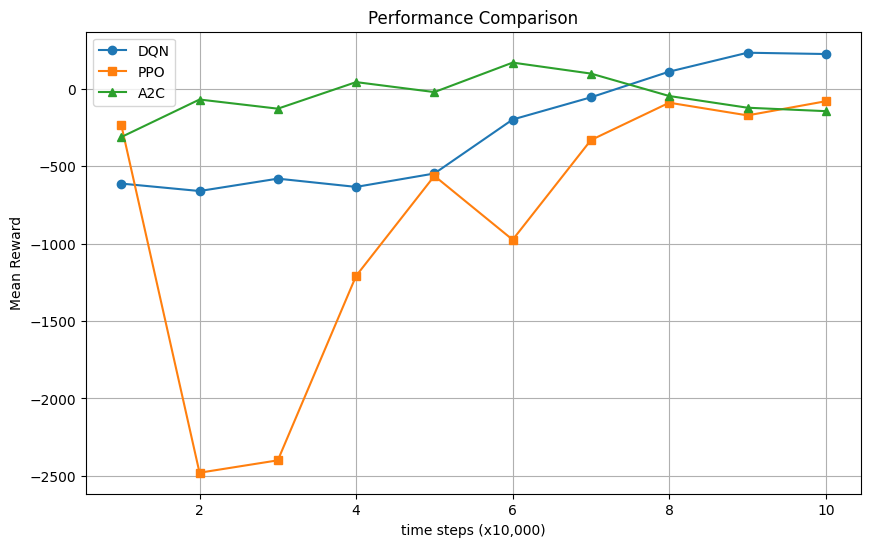

In [319]:
x = range(1,len(dqn_means)+1)

plt.figure(figsize=(10, 6))
plt.plot(x, dqn_means, label='DQN', marker='o')
plt.plot(x, ppo_means, label='PPO', marker='s')
plt.plot(x, a2c_means, label='A2C', marker='^')

# Adding titles and labels
plt.title('Performance Comparison')
plt.xlabel('time steps (x10,000)')
plt.ylabel('Mean Reward')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [315]:
print(f"DQN reward: {mean_train_dqn:9.2f}   +/- {std_train_dqn:9.2f}")
print(f"PPO reward: {mean_trained_ppo:9.2f}   +/- {std_trained_ppo:9.2f}")
print(f"A2C reward: {mean_trained_a2c:9.2f}   +/- {std_trained_a2c:9.2f}")

DQN reward:    192.81   +/-     79.21
PPO reward:    -86.44   +/-     31.28
A2C reward:  -1099.27   +/-    742.32




From the learning curve comparison above, we can see that each model had funamentally different patterns of behaviour change throughout the learning process. The DQN model was the smoothest and most consistent as it learned, but it had the mentionable behaviour that it's performance and consistency 'jumped' at around 50,000 time steps. PPO's behaviour on the other hand decreased significantly in the first quarter of it's training before increaseing significantly immediatly after and then more consistently towards the end. This seems to contrast the theory behind PPO in which it is generally known for its stability. Finally, the A2C model showed the behaviour that it peaked in performance around 60,000 time steps. This seems to indicate that it was more efficient in its training as it reached its peak performance much earlier than either of the other two models. <br>

Between the three models, DQN seemed to show the most stable learning of the three models. It also ended up with the highest mean reward after the full 100,000 training steps. Although the PPO model ended with a higher mean reward than the A2C model, the A2C model reached a peak earlier that was higher than either of those twos final performance. This indicates that the A2C model learns quicker than the PPO. It also learned quicker than the DQN, but the DQN reached a higher max value so it did end up learning to perform better in the end.

The DQN and PPO model still seemed to be increasing performance at the end of the 100,000 training steps, so it is possible that the converged value of the PPO could overtake DQN. Both would likely be higher than their current final values though, so further training could lead to a higher success rate than their current success rate of 0%, defined by the lunar landing environment as 200 points. Further training could also show whether the A2C model did indeed reach it's peak at the 60,000 mark.







## **Conclusion**<br>

From our analysis, the DQN model learns and performs the best in the Lunar Landing environment. Although the initial learning of the PPO model is very volitile, the stability evens out in further stages of training and in the end performed better than the A2C model for the allotted training. PPO was also continuing to improve performance while the performance of the A2C model was decreasing. Thus the PPO model seems to perform better in this environment and would likely continue to improve given longer time to train.

All of the models in this analysis were simple and contained no adjustments of parameters beyond the base Stable Baseline models. Further steps in this analysis would include changing the model parameters to see how these could improve or affect performance. Most of the models parameters aren't shared across the three, and so would be unhelpful in comparing the three, but two that are common across the three models are learning_rate and gamma (discount factor). Comparing the models across different values of those parameters would give us another axis on which to compare the three models.

Further analysis could also be performed by optimizing the parameters of each model to determine which actually performs the best in this environments. Due to the variability in the training process, this would entail training each parameter configuration for each model to convergence which with the current limits on computing resources in unfeasible.

From working on this project, I was impressed by the capability and ease of customization that stable baselines provided. By creating a custom basecallback class, I learned about and implemented superclasses for the first time. The ability to easily try new things and to measure the training clarified the uses but also drawbacks and intricacies of these RL methods that I realized I hadn't fully understood before.